In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import tensorflow as tf
import random
from scipy import ndimage
print(tf.__version__)

2.4.1


In [2]:
# Read Data From CSV File1
df = pd.read_csv('./slow_data/driving_log.csv', usecols= ['center','left','right','steering_angle'])

In [4]:
image_examples = df[['center','left','right','steering_angle']].to_numpy()
np.random.shuffle(image_examples)
img_num = len(image_examples)
train_num = int(0.70 * img_num)
val_num = img_num-train_num

train_examples = image_examples[0:train_num]
val_examples = image_examples[train_num:]
print("Number of Training Examples:",train_num,"Number of Validation Examples:",val_num)

def load_images (image_examples, batch_size, validation_set=False):
    examples_x = []
    examples_y = []
    length = image_examples.shape[0]
    np.random.shuffle(image_examples)
    correction = [0, 0.25, -0.25]
    i = 0
    while True:
        pos = random.randint(0,2)
        img = cv2.imread(image_examples[i][pos])
        flipped_image = np.fliplr(img)
        corrected_label = image_examples[i][3] + correction[pos]
        rand_num = random.uniform(0, 1)
        if rand_num > 0.5:
            examples_x.append(img)
            examples_y.append(corrected_label)
        else:
            examples_x.append(flipped_image)
            examples_y.append(-corrected_label)
        
        i = i+1
        
        if i%batch_size == 0:
            X = np.array(examples_x)
            y = np.array(examples_y)
            examples_x = []
            examples_y = []
            yield (X, y)
        if i == length:
            i = 0

batch_size = 32
train_gen = load_images(train_examples, batch_size)
val_gen = load_images(val_examples, batch_size, True)

EPOCHS = 10
steps_per_epoch = train_num //batch_size
validation_steps = val_num //batch_size
shape = next(train_gen)[0][0].shape

Number of Training Examples: 1932 Number of Validation Examples: 829


In [5]:
# Best Model So Far
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x : (tf.cast(x, tf.float32)/255.0) - 0.5, input_shape=shape),
    tf.keras.layers.Cropping2D(cropping=((75,25), (10,10))),
    tf.keras.layers.Conv2D(24, (5,5), padding='same'),    
    tf.keras.layers.Conv2D(36, (5,5), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1),
])
model.compile(loss='mse', optimizer='adam')

In [6]:
hist = model.fit(
    train_gen,
    epochs=EPOCHS, steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps).history

Epoch 1/10
60/60 [==============================] - 92s 2s/step - loss: 8.5649 - val_loss: 0.0531
Epoch 2/10
60/60 [==============================] - 90s 2s/step - loss: 0.0597 - val_loss: 0.0425
Epoch 3/10
60/60 [==============================] - 97s 2s/step - loss: 0.0546 - val_loss: 0.0427
Epoch 4/10
60/60 [==============================] - 91s 2s/step - loss: 0.0519 - val_loss: 0.0421
Epoch 5/10
60/60 [==============================] - 91s 2s/step - loss: 0.0483 - val_loss: 0.0388
Epoch 6/10
60/60 [==============================] - 92s 2s/step - loss: 0.0497 - val_loss: 0.0377
Epoch 7/10
60/60 [==============================] - 92s 2s/step - loss: 0.0500 - val_loss: 0.0396
Epoch 8/10
60/60 [==============================] - 91s 2s/step - loss: 0.0458 - val_loss: 0.0394
Epoch 9/10
60/60 [==============================] - 96s 2s/step - loss: 0.0421 - val_loss: 0.0375
Epoch 10/10
60/60 [==============================] - 95s 2s/step - loss: 0.0423 - val_loss: 0.0433


In [7]:
model.save('slow_model.h5')

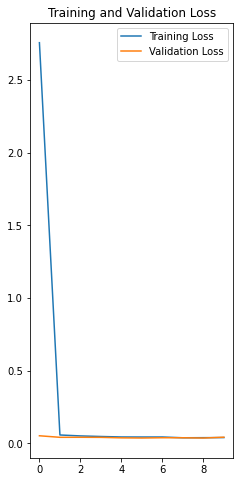

In [8]:
loss = hist['loss']
val_loss = hist['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()